<a href="https://colab.research.google.com/github/KontainPluton/TPs_Artificial_Neural_Network/blob/main/%5BTP_0%5D_My_first_Neural_Network_in_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My First Artificial Neural Network

**Objective** The goal of this practical session is to implement a simple but fully functional artificial neural network (ANN). It will probably be a first for you so be excited! This session will also be the opportunity to recall some important notions related to Machine Learning. 

**Prerequisites**: introductory level in machine learning, basics of calculus and linear algebra, a first quick introduction to ANNs, basic Python skills, and well, as usual, motivation!

**Estimated time**: 3 hours (generous)

****



## Introduction to the session

You'll be asked to implement several *tricky* details by hand. 
It will (i) force you to deeply understand the basics of neural neworks, and (ii) help you to fully understand what's happening under the hood when you'll be using high-level frameworks such as TensorFlow or PyTorch. 

*Important*: please, don't give up if you find it hard at first, we can ensure you that you've the skills and adapted background to achieve this (easily). Take your time, find your pace, try to fully understand what we are doing at each step.

As we will see later introducing PyTorch (a framework commonly used to implement ANN you're not supposed to know yet), the development process of our ANNs will be highly simplified. But for now, we will only use the Numpy library to implement the neural network.

*NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.* https://numpy.org/. It is not a prerequesite to master Numpy to understand the content of this session. The duration of this session has been defined to allow you to spend extra time learning about tools or concepts that we will use, so do not hesite to find extra resources to learn about Numpy for instance. 

This tutorial is based on https://pytorch.org/tutorials/beginner/pytorch_with_examples.html. Several modifications have been made, and extra content added to match, as much as possible, with the content given in this course and your background. 

Recall the terminology:
* supervised machine learning: the setting we will consider in which we do have a set of pairs of the form (input, label), e.g. in a binary classification task related to cancerous tumor detection in image we would have a set of pairs (image, boolean value).
* training set: labeled inputs we will use to train our network. 
* batch: group of input values processed in a iteration. 

Our aim is to obtain a predictive model, here a neural network, able to perform good predictions while used in production. It is important to stress that we don't only want our model to be good on the training set (that would be memorizing); we want our model to provide good predictions on unseen input values too. Our model should therefore generalize well.  

The flow of this session will be the following: 
1. We will define a neural network architecture in accordance with the input data we will have to deal with. Several design choices will be defined arbitrarily at this step.

2. We will define the training procedure that will be used to train the parameters of the networks using training data. You should already be familiar with the training objective classically considered in a supervised setting (i.e. minimizing a loss function; if it's not the case do not hesitate to go back to our introductory course about linear models).


## Context : Supervised setting, **Regression**

First we will define the context we will consider.

We will place ourself in a regression setting in which we want a predictor $\hat{f} :\mathbb{R}^{3} \rightarrow \mathbb{R}^{3}$.

For this illustration we will consider that we have the (x,y,z) coordinates of an object at time $t$ and that we want to predict its coordinates at time $t+1$, not knowing the dynamics of the underlying system (i.e. how the objects move in the corresponding 3D space). 

Our model should therefore be able to take inputs of the form $x_i \in \mathbb{R}^{3}$ and to produce outputs $\hat{y}_i \in \mathbb{R}^{3}$ such that $\hat{y}_i \approx y_i$. Note that we distinguish the expected output (i.e. label) for $x_i$, denoted $y_i$, from the prediction of our network denoted $\hat{y}_i$.

For pedagological reasons, we will arbitrarily and explicitly define the function ($f :\mathbb{R}^{3} \rightarrow \mathbb{R}^{3}$) we would like to approximate or find using our network. This function will be used to generate the datasets we will use. It is however important for you to understand that you'll never have access to that function in practice; you'll be only given the training set. 

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np

theta = 45

# our labeling function
def x_axis_theta_rotation(p):
  """ return new (x,y,z) coordinates of the point after a theta-based rotation along the x-axis
      Note: understanding this function is not important. 
      We could also add a random noise
  """
  return np.array([
    p[0],
    p[1]*np.cos(p[0] * theta) - p[2]*np.sin(p[0] * theta),
    p[1]*np.sin(p[0] * theta) + p[2]*np.cos(p[0] * theta)
  ])

# Generate a label example
x_1 = np.random.randn(3)
y_1 = x_axis_theta_rotation(x_1)

print("Input data example")
print("x_1", x_1)
print("y_1", y_1)


Input data example
x_1 [-0.18169342  0.00183919 -1.07256749]
y_1 [-0.18169342 -1.01794913  0.33791121]


We will have several observations of this form. 
Let's say we have *N* observations.

In [ ]:
def get_dataset(N, D_in, D_out):

  """Create N random input and associated label"""
  x = np.random.randn(N, D_in)
  y = np.array([x_axis_theta_rotation(xi) for xi in x]) 

  return (x,y)

N = 1000 # size of the dataset
D_in, D_out = 3, 3 # input and output dimensions, we name them to distinguish them hereafter

x, y = get_dataset(N, D_in, D_out)

print(x.shape)

print("Data (first 10 elements)")
print("Inputs\n", x[:10,:])
print("Labels\n", y[:10,:])

print("\nExample")
print("input 1: ", x[0])
print("label 1: ", y[0])

(1000, 3)
Data (first 10 elements)
Inputs
 [[-1.10822882  0.06684909  0.73735374]
 [ 0.72364601  0.25826799 -0.66527554]
 [ 0.59830268 -0.943151   -0.37862946]
 [ 0.32039354 -1.30071696 -0.36546543]
 [-0.310481    0.21726022 -0.33060915]
 [-1.23305997 -0.71991447  2.05594996]
 [ 0.34478398 -0.08408758 -2.43803293]
 [ 1.3478922  -0.1177895  -0.46855784]
 [-1.33540887 -0.38552227 -1.53757129]
 [-1.73216597 -0.65330972  1.49689706]]
Labels
 [[-1.10822882 -0.2221694   0.70625781]
 [ 0.72364601  0.71267067 -0.03734195]
 [ 0.59830268  0.57539667 -0.83774265]
 [ 0.32039354  0.71131628 -1.14867695]
 [-0.310481   -0.29029322 -0.26876432]
 [-1.23305997 -2.14582972  0.37499585]
 [ 0.34478398  0.54939986  2.37681196]
 [ 1.3478922  -0.31806561  0.36366892]
 [-1.33540887  0.95781737  1.26306721]
 [-1.73216597  1.37773974 -0.87712464]]

Example
input 1:  [-1.10822882  0.06684909  0.73735374]
label 1:  [-1.10822882 -0.2221694   0.70625781]


## ANN: Feedforward Neural Network

### The Model

We define the architecture of our network, which can be based on several hyperparameters (number of neurons, layers, activation functions...).

We will consider a very simple network composed of a single hidden layer with $H$ neurons using the Relu activation function.

***

#### Rectified Linear Unit (ReLU)

ReLU is a popular [activation function](https://en.wikipedia.org/wiki/Activation_function) that can be used while defining an artificial neuron. 

$\phi(z) = max(0,z)$

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6c/Rectifier_and_softplus_functions.svg/500px-Rectifier_and_softplus_functions.svg.png" alt="ReLU" width="300"/>

***
By convention, we consider inputs to be row vectors (cf. $x \in \mathbb{R}^{N \times D_{in}}$). 

Input $i$: $x_i \in \mathbb{R}^{1 \times 3}$ 

The predictive function $\hat{f} :\mathbb{R}^{3} \rightarrow \mathbb{R}^{3}$  (our neural network) will be:

$\hat{f}(x_i) = \hat{y}_i = relu(x_i W_{1}) W_{2}$ 

with: 
* $W_{1} \in \mathbb{R}^{3 \times H}$
* $relu(z) = [max(0,z_0),max(0,z_1), ...]$  
* $W_{2} \in \mathbb{R}^{H \times 3}$

**In this simple model we do not consider bias.** 

Note also that setting the number of neurons in this single-layer network, the predictions are deterministically determined by the weights $W_{1}$ and $W_{2}$. It means that the outputs of our model are fully determined by the weights of the network. Those are the sole parameters of our simple MLP (Multilayer Perceptron) model. 

Note also that we can use this network on a batch of inputs.
with $x = [x_0, x_1, ..., x_N]^T \in \mathbb{R}^{N \times 3}$.

In the following we will therefore consider: 

$\hat{f} :\mathbb{R}^{N \times 3} \rightarrow \mathbb{R}^{N \times 3}$



### First implementation


> **Exercice "Forward pass"**:
> 
> The forward pass of a network is used to compute the outputs for a batch of inputs (see $\hat{f}$ definition above).
> 
> Considering thes simple MLP model we defined, we ask you to implement the forward pass using Numpy.
> 
> Instructions:
> * According to our task, both the input and the output must be in $\mathbb{R}^{N \times 3}$. You'll denote $D_{in}$ and $D_{out}$, respectively `D_in` and `D_out` the input and output dimensions. As we already said, we here have $D_{in}=D_{out}=3$, but we want our network to be generic so reuse existing `D_in` and `D_out` variables. 
> * Define a variable `H` to set the number of neurons; we want to be able to modify it.
> * Initialize the weights randomly considering a standard normal distribution (mean=0, stdev=1). 
> * Decompose each step of the forward pass, i.e., do not use a fancy one-line expression. Only use Numpy functions to implement each step.
> * Do not define a class now, just code it into a cell.




In [ ]:
# YOUR TURN!

def relu(z):
  return np.maximum(0, z);

N = 1000 # size of the dataset
D_in, D_out = 3, 3 # input and output dimensions, we name them to distinguish them hereafter
H = 10 # number of neurons

x, y = get_dataset(N, D_in, D_out) # x <> R N*D_in (N lines = elements in dataset / D_in columns = entries)

W1 = np.random.standard_normal((D_in,H)) # W <> R D_in*H (D_in lines = entries / H columns = neurons)
z = np.dot(x,W1)
z = relu(z)

W2 = np.random.standard_normal((H,D_out)) # W <> R H*D_out (H lines = entries (1 for each neurons from the previous layer) / D_out columns = expected response)
y_pred = np.dot(z,W2)
# If you want to apply relu function on the result : 
#y_pred = relu(y_pred)

print(y_pred.shape)
print(y_pred)

(1000, 3)
[[-2.64599546 -1.70346041 -0.87333542]
 [ 0.41460598 -0.8166046   0.55247248]
 [ 2.59149368  1.86580382 -0.51907514]
 ...
 [-5.99220294 -5.39286498 -2.29919941]
 [ 2.01766761  0.77964877  0.18347276]
 [ 1.88142889 -4.58173685  2.83048545]]


Obviously, the weights being randomly defined, do not expect to have good predictions at this stage. 

Our job will now be to define a clever procedure to train those parameters in order to obtain a good predictor. 

## Training procedure



### Generalities 

Training the network will aim at finding the $W_{1}$ and $W_{2}$ matrices in order to minimize the loss function, i.e. the function we will use to evaluate the error of our model.

This error function (loss function) will be defined this way: 

$l(\hat{y}, y) = \sum_{i=0}^{N-1} \sum_{j=0}^{D_{out}-1} (\hat{y}_{i,j} - y_{i,j})^2$

*Important*: note that loss function only makes sense in a regression setting. 

with $\hat{y}, y \in \mathbb{R}^{N \times D_{out}}$

Processing the data, the weights will be iteratively modified in order to reduce the loss.

To do so, at each iteration, we will apply two passes: 
1. Forward pass: compute the loss for the processed input (it can be a subset of the whole training set or even one input). We already know how to do that (see above).
2. Backward pass: as we know the expected value for each input processed during the training phase, we can compute the loss for the current set of predictions. As we want to minimize that loss, we will:
  *  Compute the partial derivative of the loss with regards to the parameters (here $W_{1}$ and $W_{2}$), also named [gradients](https://en.wikipedia.org/wiki/Gradient) and denoted in our case $\nabla_{W_1}$ and $\nabla_{W_2}$. Those gradients will denote the direction of greatest increase of the loss, and can therefore be used to change the parameters to influence the loss (following the opposite direction, we will be able to iteratively minimize the loss). To compute this gradient, we will simply apply the chain rule considering that all functions used in our network have a derivative (chain rule: https://en.wikipedia.org/wiki/Chain_rule) - please put aside consideration induced by the relu function for now, that's not important.
  * Adjust the parameters ($W_{1}$ and $W_{2}$) applying an update rule based on the gradient, e.g. considering a constant pre-defined learning rate $\eta$, this rule could be $W_1 = W_1 - \eta \times \nabla_{W_1}$. This is called backpropagation. 

Computing the gradients is probably the most technical part, but it should not be a problem as it only requires to compute derivative.
We provide a sketch to compute $\nabla_{W_2}$ (using shortcut notations):



$\frac{\partial l}{\partial W_2} = \frac{\partial l}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial W_2}$

$\frac{\partial l}{\partial \hat{y}} = 2 (\hat{y} - y)$ $\in \mathbb{R}^{N \times D_{out}}$ 

$\frac{\partial \hat{y}}{\partial W_2} : relu(x_i W_{1})$ $\in \mathbb{R}^{N \times H}$ (shortcut)

$\frac{\partial l}{\partial W_2} =  relu(x_i W_{1})^T \cdot (2 (\hat{y} - y))$ $\in \mathbb{R}^{H \times D_{out}}$, recall that $W_2 \in \mathbb{R}^{H \times D_{out}}$ 

Details on how to compute the gradient on linear models (considering multivariate calculus) are provided in that resource: https://web.eecs.umich.edu/~justincj/teaching/eecs442/notes/linear-backprop.html


### First implementation

> **Exercise: Training procedure implementation**
>
> You can now try to implement the training procedure

We define below our first implementation of the training procedure

0 33268.76710554114


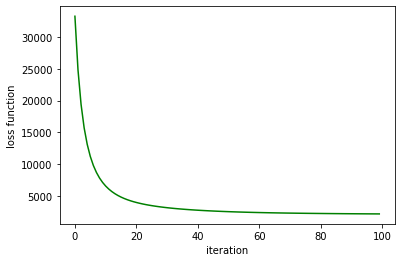

In [ ]:
# YOUR TURN!

import matplotlib.pyplot as plt

N = 1000 # size of the dataset
D_in, D_out = 3, 3 # input and output dimensions, we name them to distinguish them hereafter
H = 10 # number of neurons
J = 100 # number of iterations
eta = 1e-5 # learning rate

x, y = get_dataset(N, D_in, D_out) # x <> R N*D_in (N lines = elements in dataset / D_in columns = entries)

W1 = np.random.standard_normal((D_in,H)) # W <> R D_in*H (D_in lines = entries / H columns = neurons)
W2 = np.random.standard_normal((H,D_out)) # W <> R H*D_out (H lines = entries (1 for each neurons from the previous layer) / D_out columns = expected response)

lossForEachIteration = []

# ITERATIONS
for j in range(0,J):

  z = np.dot(x,W1)
  z_relu = relu(z)
  y_pred = np.dot(z_relu,W2)

  # Compute square loss
  squaredMatrix = np.square(y_pred - y) # Square up a matrix
  loss = squaredMatrix.sum() # Sum of all the elements of the matrix

  if j % 1000 == 0:
    print(j, loss)

  lossForEachIteration = np.append(lossForEachIteration, loss)

  # Now we must modify the weights in order to reduce the loss
  # We compute the partial derivative applying the chain rule for this
  # Backpropagation to compute gradients of w1 and w2 with respect to loss
  # This the most technical part 
  gradient_y_pred = 2 * (y_pred - y)
  gradient_W2 = np.dot(z_relu.T,gradient_y_pred)
  gradient_z_relu = np.dot(gradient_y_pred,W2.T)
  gradient_z_relu[z < 0] = 0
  gradient_W1 = np.dot(x.T,gradient_z_relu)

  # Update weights using the gradient and the learning rate.
  W1 -= eta * gradient_W1
  W2 -= eta * gradient_W2

plt.plot(np.arange(0,J),lossForEachIteration,color='green')
plt.xlabel('iteration')
plt.ylabel('loss function')
plt.show()

As we can see, it looks like our network is learning something. 

To be more precise, the training procedure we defined enables to iteratively minimize the loss (on the training set). 

## Refactoring / Refinements

Let's restructure the code in order to distinguish the different parts.
Several approaches could have been chosen (and a lot of choices could be discussed and questioned in term of design, but that's not the aim of the course). 

### Model implementation


> **Exercise: refactoring**
>
> Refactor the code. Create a class `SimpleANN` with a constructor enabling to define $D_{in}$, $D_{out}$, $H$.
>
> Define a `forward` method in which you'll implement the forward pass (the method returns the prediction).

In [ ]:
# YOUR TURN!

class SimpleANN:
  """
    Simple single-layer artificial neural network (ANN) 
  """
  def __init__(self,D_in: int, D_out: int, H: int):
    """
      H: number of neurons in the hidden Layer
    """
    self.w1 = np.random.standard_normal((D_in,H))
    self.w2 = np.random.standard_normal((H,D_out))
    
  def forward(self, x):
    z = x.dot(self.w1)
    z_relu = relu(z)
    y_pred = z_relu.dot(self.w2)

    return y_pred

### Trainer implementation

In [ ]:
# YOUR TURN!

class Trainer:
  """
    Simple class implementing a Trainer that will be used
    to modify our SimpleANN parameter to minimize the loss
  """

  def __init__(self, ann: SimpleANN, training_set):
    self.learning_rate = 1e-6 
    self.ann = ann
    self.x, self.y = training_set

  def compute_loss(self, y_pred, y):
    return np.square(y_pred - y).sum()
    

  def step(self):
    
    y_pred = self.ann.forward(self.x)
    loss = self.compute_loss(y_pred, self.y)
    
    # backward step
    # requires some information already computed in the forward step
    z = self.x.dot(self.ann.w1)
    z_relu = relu(z)

    gradient_y_pred = 2.0 * (y_pred - y)
    gradient_w2 = z_relu.T.dot(gradient_y_pred)
    gradient_z_relu = gradient_y_pred.dot(self.ann.w2.T)
    gradient_z_relu[z < 0] = 0
    gradient_w1 = self.x.T.dot(gradient_z_relu)

    # Update weights using the gradient and the learning rate.
    self.ann.w1 -= self.learning_rate * gradient_w1
    self.ann.w2 -= self.learning_rate * gradient_w2

    return loss

  def fit(self, epoch: int, log_frequency: int):

    log_loss = [] # we just log the loss

    for i in range(epoch+1):
      loss = self.step()
      if i % log_frequency == 0:
        print(i, loss)
        log_loss.append((i,loss))
    return log_loss

### Training tests

We can now easily reimplement the training loop

0 32533.56223436805
1000 2466.951251280512
2000 2253.9173754935587
3000 2173.240456426336
4000 2129.0019786058
5000 2094.818551332386
6000 2058.933953340004
7000 2033.8097122412382
8000 2011.5115826983576
9000 1993.3791647032185
10000 1976.9532765655454
11000 1965.2296724797152
12000 1957.7448418944953
13000 1952.009751999581
14000 1947.070129730576
15000 1943.2394965315984
16000 1940.1558937412633
17000 1937.3499675518733
18000 1934.3476602303076
19000 1931.6252054041106
20000 1929.410893219401


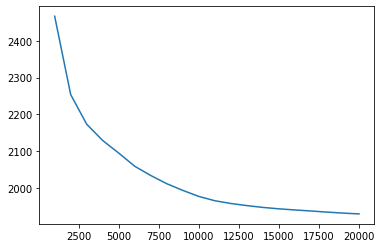

In [ ]:
# YOUR TURN!

ann = SimpleANN(D_in=3, D_out=3, H=H)

trainer = Trainer(ann, (x, y))
log_loss = trainer.fit(epoch=20000, log_frequency=1000)

# plotting
import matplotlib.pyplot as plt
del log_loss[0] # we remove the first loss (random weights)
res = list(zip(*log_loss)) 
plt.plot(res[0], res[1])

Let's see how our neural network performes on unseen data : the only things that matters for us.

To do so we will generate another set of labelled data not used during training.

In [ ]:
# YOUR TURN!

# recall the loss we finally obtained after the training phase 
y_pred = ann.forward(x)
training_loss = trainer.compute_loss(y_pred, y)

# Let's now generate a test set (data not used during training)
x_test, y_test = get_dataset(N, D_in, D_out)

y_pred_test = ann.forward(x_test)
test_loss = trainer.compute_loss(y_pred_test, y_test)

# due to the way the loss has been defined the two sets must have the same size
# in order for us to compare the loss
assert x.shape[0] == x_test.shape[0]

print("training loss: ", training_loss)
print("test loss    : ", test_loss)
print("diff         : ", abs(training_loss - test_loss))

training loss:  1929.4086458487739
test loss    :  2104.621767102415
diff         :  175.21312125364125


Well... even if results may vary from run to run, it looks like our neural network is pretty good on the training set but fails to perform similarly on the test set... we don't like this at all.
We are maybe overfitting, i.e. memorizing the training set. 

### Train, Validation, Test 



To monitor, and eventually overcome this, we will split our initial labelled dataset into 3 parts: 
* training set: the data we will use to update the weights of our network
* validation set: the data we will use to monitor that we are not overfitting the training set during training
* test set: the data we will use to evaluate our trained ANN on data not used during the training phase

We will monitor our loss on the validation set during training and stop when the difference between our training and validation losses stresses overfitting.

We will modify our trainer to accept a validation set. 

In [ ]:
# YOUR TURN!

class TrainerAdvanced(Trainer):
  """
    Simple Trainer with validation
  """

  def __init__(self, ann: SimpleANN, training_set, validation_set):
    Trainer.__init__(self, ann, training_set)
    self.x_val, self.y_val = validation_set
    
  def fit(self, epoch: int, log_frequency: int):

    log_loss = [] # we just log the losses

    for i in range(epoch+1):
      
      loss_train = self.step()

      if i % log_frequency == 0:

        # validation part
        y_pred_val = self.ann.forward(self.x_val)
        loss_val = self.compute_loss(y_pred_val, self.y_val)

        log_loss.append((i, loss_train, loss_val))
        loss_train_evol = 0 if len(log_loss) == 1 else loss_train - log_loss[len(log_loss)-2][1]
        loss_val_evol = 0 if len(log_loss) == 1 else loss_val - log_loss[len(log_loss)-2][2]
        
        print("{} train: {:.2f}   valid: {:.2f}   diff: {:.2f}   loss train ev.: {:.2f}   loss val ev.: {:.2f}".format(i, loss_train, loss_val, loss_train - loss_val, loss_train_evol, loss_val_evol))
    return log_loss 

Let's train our model using that new Trainer.

Note that we already have a training set, and test set. 
We will only create a validation. 
Generally you'll have to split an initial dataset to obtain those sets.

0 train: 1929.41   valid: 2101.63   diff: -172.22   loss train ev.: 0.00   loss val ev.: 0.00
1000 train: 1927.29   valid: 2100.31   diff: -173.02   loss train ev.: -2.12   loss val ev.: -1.32
2000 train: 1925.49   valid: 2099.08   diff: -173.59   loss train ev.: -1.80   loss val ev.: -1.23
3000 train: 1923.88   valid: 2098.08   diff: -174.20   loss train ev.: -1.61   loss val ev.: -1.00
4000 train: 1922.43   valid: 2097.40   diff: -174.96   loss train ev.: -1.45   loss val ev.: -0.69
5000 train: 1921.44   valid: 2096.77   diff: -175.33   loss train ev.: -1.00   loss val ev.: -0.63
6000 train: 1920.58   valid: 2096.51   diff: -175.93   loss train ev.: -0.86   loss val ev.: -0.26
7000 train: 1919.86   valid: 2096.43   diff: -176.57   loss train ev.: -0.72   loss val ev.: -0.08
8000 train: 1919.30   valid: 2096.50   diff: -177.20   loss train ev.: -0.56   loss val ev.: 0.07
9000 train: 1918.81   valid: 2096.60   diff: -177.80   loss train ev.: -0.49   loss val ev.: 0.10
10000 train: 1918

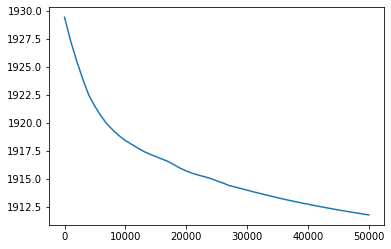

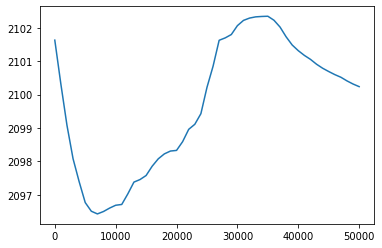

In [ ]:
# YOUR TURN!

# we use the network already trained above
#ann = SimpleANN(D_in=3, D_out=3, H=H)

x_val, y_val = get_dataset(N, D_in, D_out)

assert x.shape[0] == x_val.shape[0]

trainer = TrainerAdvanced(ann, (x, y), (x_val, y_val))
log_loss = trainer.fit(epoch=50000, log_frequency=1000)

import matplotlib.pyplot as plt
def plot_losses(log_losses):
  # del log_loss[0] # remove the first loss if you train a new network
  res = list(zip(*log_loss)) 
  plt.plot(res[0], res[1])
  plt.show()
  plt.plot(res[0], res[2])

plot_losses(log_loss)

It looks like we indeed obtain a better loss on the training set compared to the one obtained on the validation set. 

But we are still reducing the validation loss during training (which means we are not overfitting per se).

Let's continue training.

In [ ]:
log_loss = trainer.fit(epoch=100000, log_frequency=5000)
plot_losses(log_loss)

[Optional] Execute the code below to plot the full evolution of the losses training a new network from scratch

In [ ]:
ann = SimpleANN(D_in=3, D_out=3, H=H)
trainer = TrainerAdvanced(ann, (x, y), (x_val, y_val))
log_loss = trainer.fit(epoch=100000, log_frequency=1000)

del log_loss[0]
plot_losses(log_loss)

## Takeaway

You've implemented your first ANN. 

Ok it was a quite simple ANN, but you can still be proud of you!

We will now try to extract the main notions you're supposed to grasp having endured that adventure. 

**A task-dependent ANN model with specific design choices**

The architecture of our ANN has been defined based on the task we were adressing. Recall that in our case we were dealing with a specific regression task in which our predictior (ANN) was of the form: $\hat{f}: \mathbb{R}^3 \rightarrow \mathbb{R}^3$. Always keep in mind what's your goal: given the (x,y,z) 3D coordinates of an object at time $t$, we were asked to predict the location of the object in that same space at time $t+1$.

Hence, even if we tried to be as generic as possible, e.g. introducing $D_{in}$ and $D_{out}$ to refer to the input, and output sizes, those values, among others, had to be defined to even think about effectively using the ANN, i.e. to make predictions. This was required to process a given input and produce an output because the shapes of $ W_1 $ and $ W_2 $ were also dependent of these values.

In our case we defined $D_{in} = D_{out} = 3$ because of the task we were dealing with ($\hat{f}: \mathbb{R}^3 \rightarrow \mathbb{R}^3$). Dealing with another task, e.g. classification task, and/or the need to process other types of inputs, or to produce other outputs would require us to make potentially important modifications to our network. This has to be very clear to you.

Designing our network, we also arbitrarily defined several things related to its architecture : we chose to only use a single hidden layer, with a specific number of neurons ($H$), that were characterized by a similar activation function (ReLU). The type of ANN we finally defined is called a [feedforward neural network](https://en.wikipedia.org/wiki/Feedforward_neural_network) (no cycles in the flow of information).

All these design choices could have been different. We could have changed the number of neurons, the number of layers, the activation function, even the connexions between neurons. Once again, those choices had to be defined in order to obtain a usable network, as they define the way the output will be computed from an input. 

Expert in machine learning and deep learning knowing the litterature generally have an idea of what types of networks are more susceptible to work dealing with a specific task. They also know how to apply well-defined procedures to train various models and compare their results in a meaningfull way, which is always mandatory in the end to train and obtain a new network trained for a specific task on new data.

We therefore distinguish: 
* Type of networks: feedforward, recurrent...
* hyperparameters: number of layers, neurons, types of activation function...
* parameters: weights (and bias) of the network that are effectively trainable (values stored in $W_1$ and $W_2$ in our case).  

The architecture of the network and the hyperparameters define the way the function mapping the input to the output is constrained (it defines a set of functions). 

The parameters are implicitly defined by the design of the network, e.g. in our simple network, the hyperparameters $D_{in}$, $D_{out}$ and $H$ are defining the shapes of the matrices $W_1$ and $W_2$ storing the networks' parameters. 

Once fixed, i.e. assigned to a specific value, the parameters finally fully define the predictor, the function $\hat{f}$ we will be able to use to map an input to an output.     

**The general training procedure is not tight to a specific ANN or Task**

The training procedure has been used to find the good values of the parameters with regard to a specific objective we defined. 

The objective we considered is the minimization of a loss function (it get more complex when we distinguish training, validation and test losses but don't get lost, what we wanted was to minimize a loss considering specific constraints). 

Recall, the training procedure we used. 
It worked iteratively as follows: 

* We iterate several times on the training data (eventually processing splits):
  1. Forward pass: The predictor is used to makes predictions on the given inputs.
  2. Backward pass: 
    * We compute the training loss comparing expected values and predictions
    * We compute the gradient of the loss function with respect to the parameters of the ANN.
    * We modify the parameters using the gradient.  
  3. We evaluate a stopping criterion (e.g. based on the loss on a validation set)

Obviously, this is a general sketch and each step contains technical aspects. However, the procedure is fully generic considering that: 
* the ANN is given 
* the loss is defined
* we can compute the gradient of the loss function with respect to the parameters of the ANN (which was in the end the only technical part we had to deal with)


Now, read carefully, let's imagine a world where, considering a loss and a set of labeled inputs, computing the gradient of the loss function with respect to the parameters of an ANN would be as easy as calling a function once the forward pass of the ANN is defined. Read again. 

AS we will see in the nex session, this world exists, it's yours! 


> **Exercise "Explain me what's an ANN."**
>
> Developing ANNs in the following sessions will require you to master the basic concepts. Take a sheet of paper. 
>  
> Considering a supervised setting:
> * Introduce what's an ANN; distinguish the main components, illustrate and formalize them.
> * Explain how to train an ANN considering a specific dataset.  
> * Express an illustration of simple network using Linear Algebra notations we used in the course (it will be important for you to understand this for the next sessions). 
> 

## Resources 
* [Machine learning](https://en.wikipedia.org/wiki/Machine_learning)
* [Supervised learning](https://en.wikipedia.org/wiki/Supervised_learning)
* [Feedforward neural networks](https://en.wikipedia.org/wiki/Feedforward_neural_network)
* [Backpropagation](https://en.wikipedia.org/wiki/Backpropagation)
* [Chain rule](https://en.wikipedia.org/wiki/Chain_rule)


********